In [1]:
from os import path

import numpy as np
import torch

from trajectory_prediction.compare_baseline import compare_baselines
from trajectory_prediction.utils import (
    compute_batch_ade_ret,
    compute_batch_fde_ret,
    get_dataloader,
)

try:
    from trajectory_prediction.gpt import predict_trajectory_v2 as predict_trajectory
except ImportError:
    from trajectory_prediction.gpt import predict_trajectory

In [7]:
obs_len = 8
pred_len = 12
batch_size = 32

# datasets = ["eth", "hotel", "univ", "zara1", "zara2"]
datasets = ["eth"]
# datasets = ["hotel"]
# datasets = ["zara1"]

all_results = {}

In [8]:
NUM_TRAJECTORIES = 20 # expected for minADE20

for dataset_name in datasets:
    print(f"\nProcessing dataset: {dataset_name.upper()}")

    dataset_dir = path.join("datasets", dataset_name)

    loader_test = get_dataloader(dataset_dir, 'test', obs_len, pred_len, batch_size=1)

    ade_list = []
    fde_list = []

    predictions = []

    results = []
    for i, batch in enumerate(loader_test):
        input_traj = batch[0].numpy()  # [num_agents, obs_len, 2]
        target_traj = batch[1].numpy()  # [num_agents, pred_len, 2]


        gpt_prediction = predict_trajectory(input_traj)
        gpt_prediction_tensor = torch.tensor(gpt_prediction)
        target_traj = torch.tensor(target_traj)
        minade, minade_idx, ade_all = compute_batch_ade_ret(
            gpt_prediction_tensor, target_traj
        )  # ade_all [NUM_TRAJECTORIES,]
        minfde, minfde_idx, fde_all = compute_batch_fde_ret(
            gpt_prediction_tensor, target_traj
        )  # fde_all [NUM_TRAJECTORIES,]
        assert (
            ade_all.shape[0] == NUM_TRAJECTORIES
        ), f"ade first shape should be {NUM_TRAJECTORIES}, but got {ade_all.shape[0]}"

        mixed_goal = 0.6 * minade + 0.4 * minfde

        results.append(
            {
                "traj_idx": i,
                "minade_idx": minade_idx,
                "minfde_idx": minfde_idx,
                "minade": minade,
                "minfde": minfde,
                "mixed_goal": mixed_goal,
            }
        )

    avg_best_ade = np.mean([traj_result["minade"] for traj_result in results])
    avg_best_fde = np.mean([traj_result["minfde"] for traj_result in results])
    avg_best_mixed_goal = np.mean(
        [traj_result["mixed_goal"] for traj_result in results]
    )

    print("[*] Average metrics with per-trajectory optimal parameters:")
    print(f"    ADE: {avg_best_ade:.4f}")
    print(f"    FDE: {avg_best_fde:.4f}")
    print(f"    Mixed Goal: {avg_best_mixed_goal:.4f}")

    all_results[dataset_name.upper()] = {"ADE": avg_best_ade, "FDE": avg_best_fde}


Processing dataset: ETH
[*] Average metrics with per-trajectory optimal parameters:
    ADE: 0.5350
    FDE: 0.9446
    Mixed Goal: 0.6988


In [9]:
compare_baselines(all_results["ETH"]["ADE"], all_results["ETH"]["FDE"], "ETH")
# compare_baselines(all_results["HOTEL"]["ADE"], all_results["HOTEL"]["FDE"], "HOTEL")
# compare_baselines(all_results["ZARA1"]["ADE"], all_results["ZARA1"]["FDE"], "ZARA1")

Dataset: ETH
Model Name                    	   ADE	   ADE Gap	   FDE	   FDE Gap
---------------------------------------------------------------------------
Social-LSTM                   	  1.09	  +202.78%	  2.35	  +343.40%
Social-GAN                    	  0.87	  +141.67%	  1.62	  +205.66%
STGAT                         	  0.65	   +80.56%	  1.12	  +111.32%
Social-STGCNN                 	  0.64	   +77.78%	  1.11	  +109.43%
PECNet                        	  0.61	   +69.44%	  1.07	  +101.89%
Trajectron++                  	  0.61	   +69.44%	  1.03	   +94.34%
SGCN                          	  0.57	   +58.33%	  1.00	   +88.68%
LB-EBM                        	  0.60	   +66.67%	  1.06	  +100.00%
AgentFormer                   	  0.46	   +27.78%	  0.80	   +50.94%
ExpertTraj                    	  0.37	    +2.78%	  0.65	   +22.64%
MemoNet                       	  0.40	   +11.11%	  0.61	   +15.09%
Social-Implicit               	  0.66	   +83.33%	  1.44	  +171.70%
MID                           	  0.39	  

Data shape: (5492, 4)
Number of frames: 876
Number of agents: 360

Scenario 1/3 - Frame 10370.0, 5 pedestrians
Prediction shape: (20, 5, 12, 2)
Scenario 1 - Frame 10370.0:
Best prediction (index 9):
  ADE: 1.0992
  FDE: 1.6152
  Mixed Goal: 1.3056


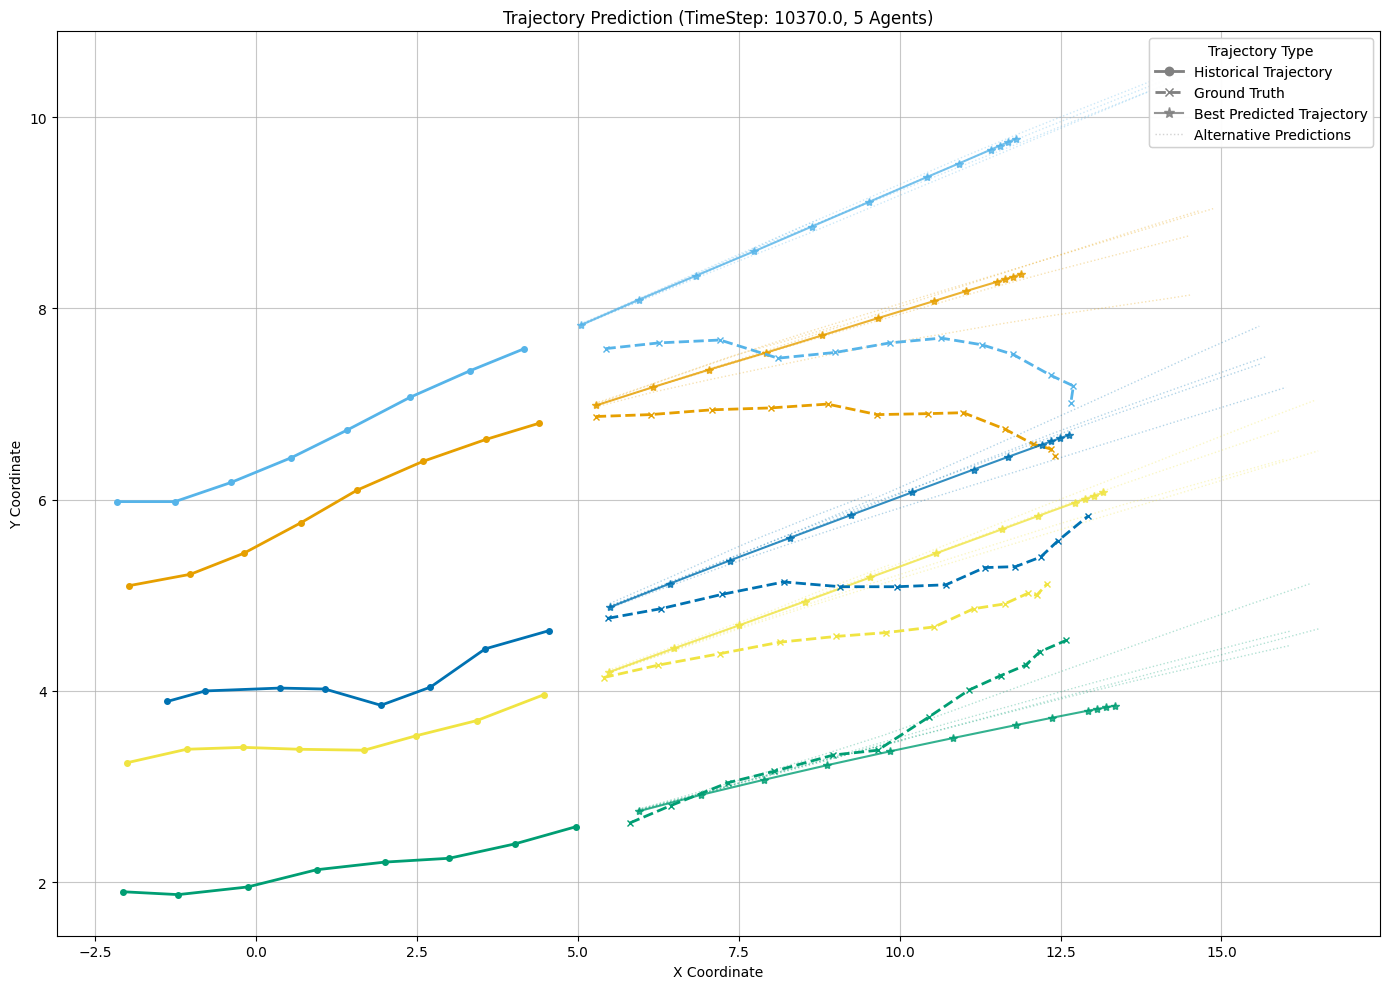


Scenario 2/3 - Frame 8980.0, 4 pedestrians
Prediction shape: (20, 4, 12, 2)
Scenario 2 - Frame 8980.0:
Best prediction (index 1):
  ADE: 0.8629
  FDE: 2.2681
  Mixed Goal: 1.4250


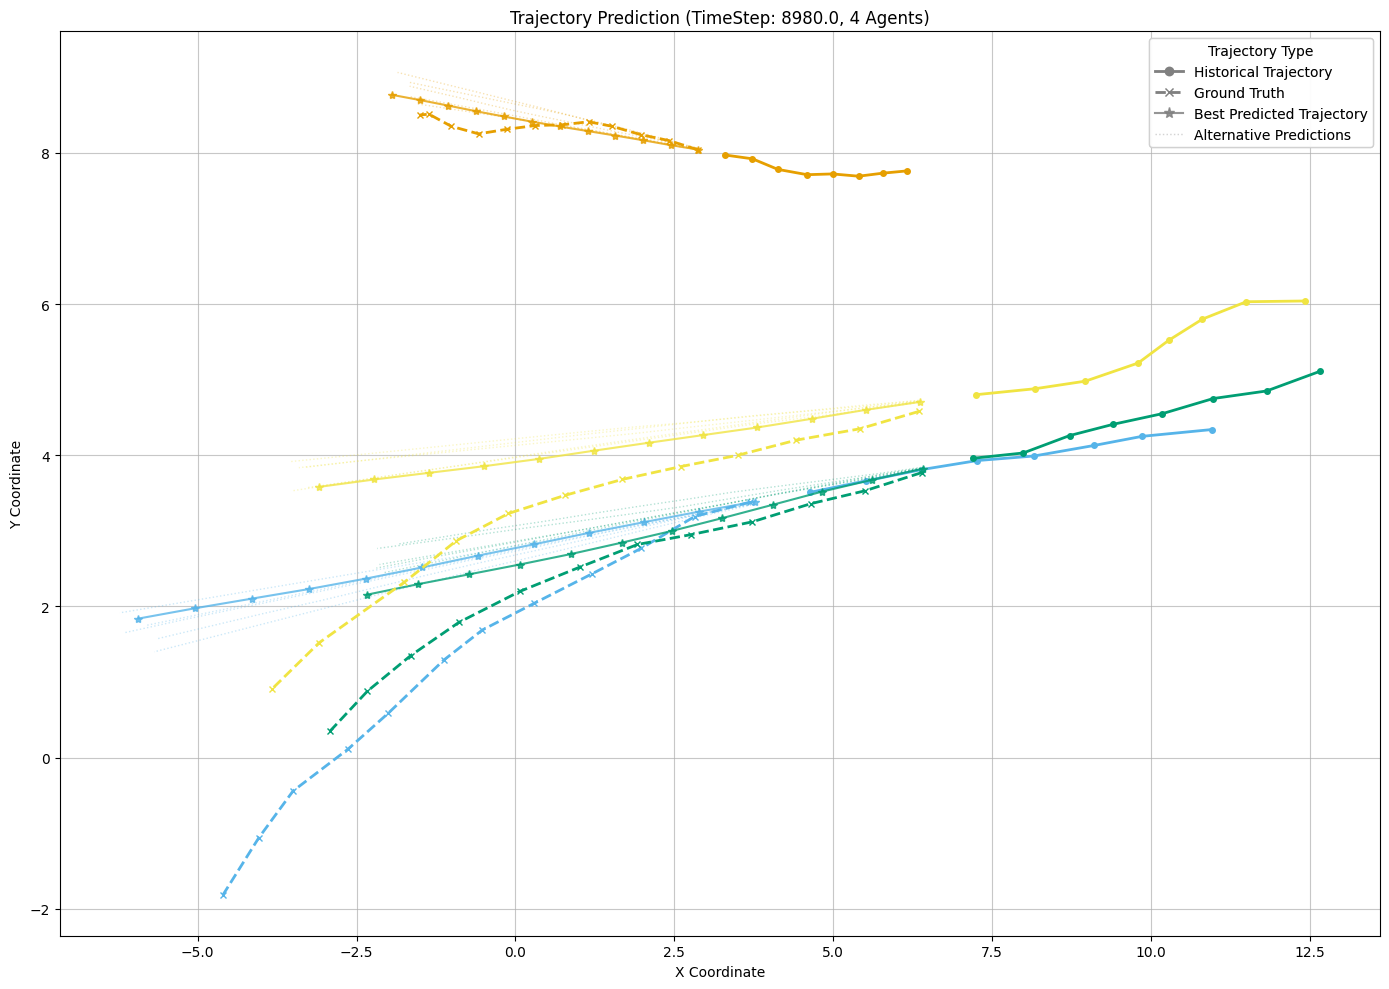


Scenario 3/3 - Frame 10320.0, 4 pedestrians
Prediction shape: (20, 4, 12, 2)
Scenario 3 - Frame 10320.0:
Best prediction (index 18):
  ADE: 1.0095
  FDE: 2.2560
  Mixed Goal: 1.5081


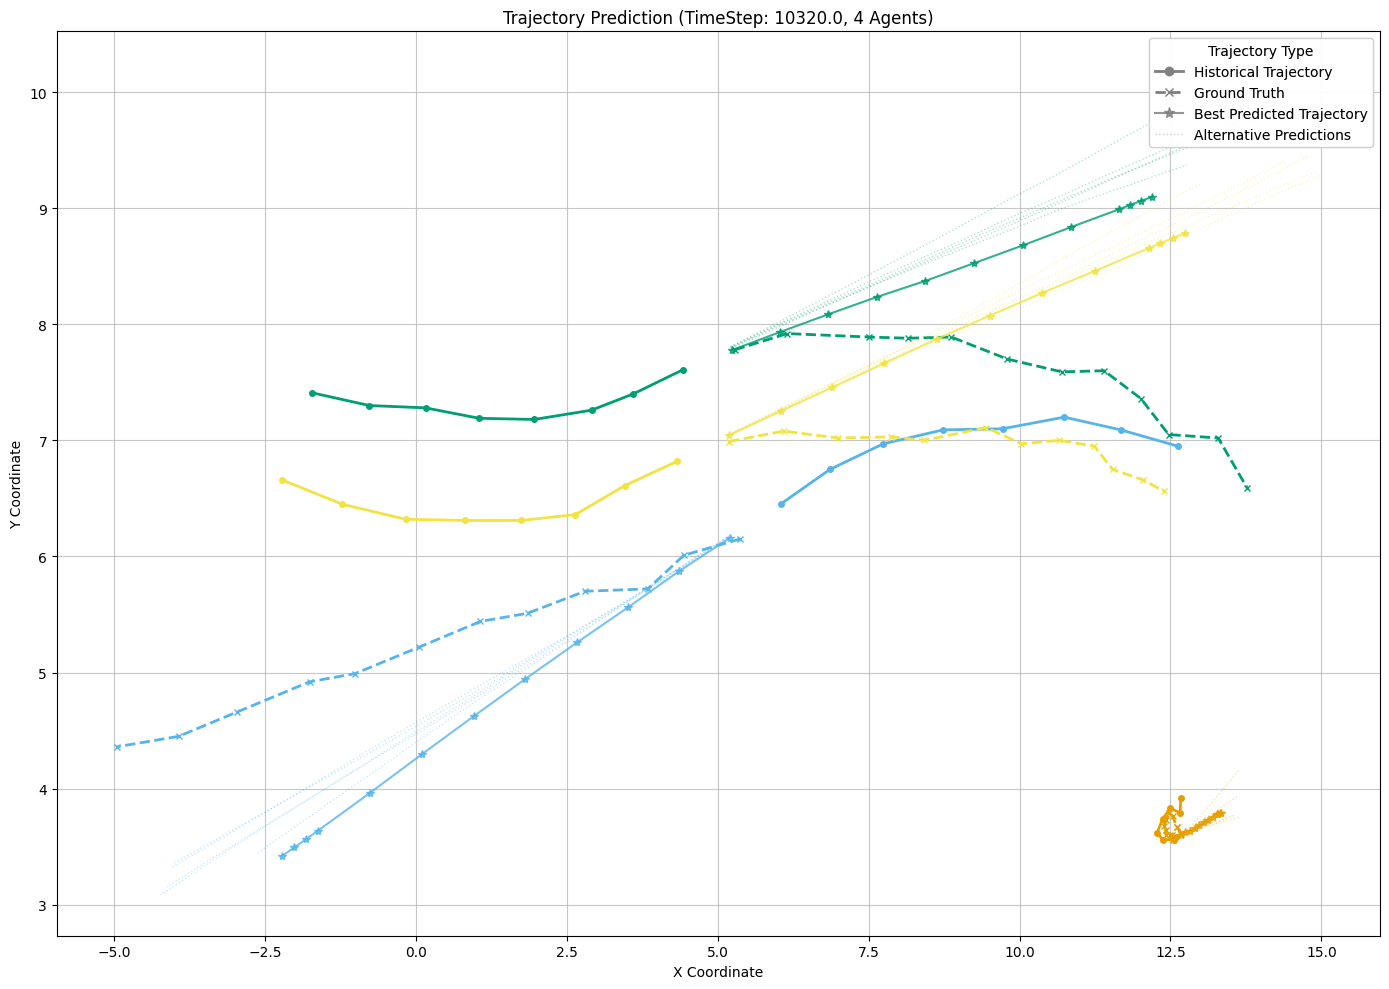

In [5]:
from visual import main

main()